In [22]:
from cupy import array, bincount, argmax, max as cmax, where
y2 = array([0,0,0,0,1,1,1,8,7,7,7,7,7,7,7,7,2,2,2,2,3,3,3,3,3,3,4,4,4,3,0,0,0,0,0,0,0,0])
binc = bincount(y2)
maxLabel = argmax(binc[1:]) + 1
maxLabelcount = cmax(binc[1:])
print("y2 : ", y2, "\ny2.bincount : ", binc)
print("maxLabel: ", maxLabel, "maxLabelcount : ", maxLabelcount)
# 확률로 변환, maxLabel => 1.2, 0번 label => 0.8, 나머지 label => 1 

y2 = where(y2 == maxLabel, 1.2, where(y2 == 0, 0.8, 1))
y2
#     y2 = where(y2 == maxLabel, 1.2, ())

y2 :  [0 0 0 0 1 1 1 8 7 7 7 7 7 7 7 7 2 2 2 2 3 3 3 3 3 3 4 4 4 3 0 0 0 0 0 0 0
 0] 
y2.bincount :  [12  3  4  7  3  0  0  8  1]
maxLabel:  7 maxLabelcount :  8


array([0.8, 0.8, 0.8, 0.8, 1. , 1. , 1. , 1. , 1.2, 1.2, 1.2, 1.2, 1.2,
       1.2, 1.2, 1.2, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8])

In [31]:
from cupy import array, bincount, argmax, max as cmax, where
y2 = array([-1, 0, 1,2,3,4,4,3,2,3,4,5])
if -1 in y2:
    y2 += 1
y2

array([0, 1, 2, 3, 4, 5, 5, 4, 3, 4, 5, 6])

In [ ]:
"""hdbscan auto hyperparameter"""
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cupy as cp
import hdbscan
from sklearn.preprocessing import RobustScaler
from functions import data_load, randomSampling, trip_Distance, Calculate_distance,\
Calculate_Matrix, dbcluster, mat2, pick

dclus, pp, dd = data_load()

def myHdbscan(train_data_robustScaled, cluster_size):
    """auto HBSCAN"""
    test_data = train_data_robustScaled
    clusterer = hdbscan.HDBSCAN(min_cluster_size = cluster_size, gen_min_span_tree=False, prediction_data =True)
    clusterer.fit(test_data)
    return clusterer, np.unique(clusterer.labels_).shape[0] # label갯수 리턴

# def ScaledHdbscan(idx, pp, cluster_size = 7):
from sklearn.preprocessing import RobustScaler
# parameter
# idx += 1

outlier=[]
for idx in range(len(pp)):
    cluster_size = 7

    #outlier 잡기 : Scaling
    robustScaler = RobustScaler()
    train_data = pp[idx][:, :2]
    train_data = cp.asnumpy(train_data)
    robustScaler.fit(train_data)
    train_data_robustScaled = robustScaler.transform(train_data)
    # return myHdbscan(train_data_robustScaled, cluster_size) # 4 ~ 8
    # Hdbscan 적용
    clusterer, labelNum  = myHdbscan(train_data_robustScaled, cluster_size) # 4 ~ 8
    print (clusterer, labelNum)
    """ dbscan autoScaling"""
    cnt = 0
    while labelNum > 15:
        cnt += 1
        if cnt >10:
            print ("10넘음")
            break

        # cluster_size 낮춰서
        cluster_size += 1
        clusterer, labelNum = myHdbscan(train_data_robustScaled, cluster_size)
    
    if labelNum < 3:
        cluster_size += 1
        clusterer, labelNum = myHdbscan(train_data_robustScaled, cluster_size)
        cluster_size -= 1
    
    while labelNum < 3:
        cnt += 1
        if cnt > 4:
            print("labelNum < 3")
            break
        cluster_size -= 1
        clusterer, labelNum = myHdbscan(train_data_robustScaled, cluster_size)

    #         # cluster_size 줄여가며
    #         if cluster_size2 > 2:
    #             cluster_size2 -= 1
    #             clusterer2, labelNum2 = autoHdbscan(train_data_robustScaled, cluster_size2)

    #         if labelNum1 >= 3 and labelNum1 <= 8:
    #             clusterer, labelNum, cluster_size = clusterer1, labelNum1, cluster_size1
    #             break

    #         if labelNum2 >= 3 and labelNum2 <= 8:
    #             clusterer, labelNum, cluster_size = clusterer2, labelNum2, cluster_size2
    #             break

    #         if cluster_size1 >= 20 and cluster_size2 <= 2:
    #             print("Can't run autoHdbscan\n")
    #             break

    # label 수
    print("idx: ",idx,"\ncnt: ", cnt, "\nlabelNum: ", labelNum, "\ncluster_size: ", cluster_size, "\nclusterer.labels_.shape: ",clusterer.labels_.shape)

    if labelNum > 15:
        outlier.append(idx)
        
    for i in np.unique(clusterer.labels_):
        print(i, "Label count : " ,clusterer.labels_[clusterer.labels_ == i].size)

    color_palette = sns.color_palette('deep', 60)
    cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
    plt.scatter(*train_data.T, s=10, linewidth=0, c=cluster_member_colors, alpha=0.6)
    plt.show()
    plt.clf()
print(outlier)

C:\Users\Jun\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()
C:\Users\Jun\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: covariance is not positive-semidefinite.


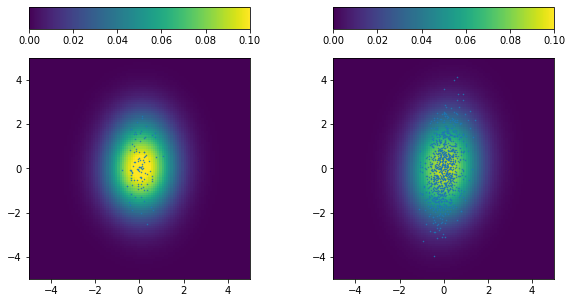